In [1]:
import numpy as np
import operator

In [2]:
def createDataSet():
    group = np.array([[1.0, 1.1],
                    [1.0, 1.0],
                    [0, 0],
                    [0, 0.1]])
    labels = ['A', 'A', 'B', 'B']
    return group, labels

In [3]:
group, labels = createDataSet()
print(group)
print(labels)

[[1.  1.1]
 [1.  1. ]
 [0.  0. ]
 [0.  0.1]]
['A', 'A', 'B', 'B']


# kNN伪代码
1. 计算已知类别数据集中的点与当前点之间的距离
2. 按照距离递增次序排序
3. 选取与当前点距离最小的k个点
4. 确定前k个点所在类别的出现频率
5. 返回前k个点出现频率最高的类别作为当前点的预测分类

In [4]:
def classify0(inX, dataSet, labels, k):
    '''1.使用欧式距离公式计算距离'''
    dataSetSize = dataSet.shape[0] #获取行数
    diffMat = np.tile(inX, (dataSetSize, 1)) -dataSet
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1) #axis=1时为矩阵每行向量和 axis=0时为对应列相加
    distances = sqDistances**0.5

    '''2.排序'''
    sortedDistIndicies = distances.argsort() #从小到大排序后提取索引
    '''4.确定出现频率'''
    classCount = {}
    for i in range(k):
        voteIlable = labels[sortedDistIndicies[i]]
        classCount[voteIlable] = classCount.get(voteIlable, 0) + 1
        #返回字典元素对应的值+1，如果无则初始化为0
    
    sortedClassCount = sorted(classCount.items(),
    key=operator.itemgetter(1), reverse=True)
    #iteritems()将字典分解为元组列表[key][value]
    #python3.9无iteritems(),改为items()
    #itemgetter(1)读取元组的第2列
    return sortedClassCount[0][0]


In [5]:
classify0([0, 0], group, labels, 3)

'B'

# 使用kNN算法改进约会网站配对效果
该例子的数据存放在文本文件datingTestSet2.txt中  
需要先将读取文本文件并转化为矩阵  
文本中的数据格式如下  
40920	8.326976	0.953952	3  
14488	7.153469	1.673904	2  
26052	1.441871	0.805124	1  
75136	13.147394	0.428964	1  
38344	1.669788	0.134296	1  

In [6]:
def file2matrix(filename):
    '''读取文本文件并转化为矩阵'''
    fr = open(filename)
    arrayOfLines = fr.readlines()
    numberOfLines = len(arrayOfLines) #获取文件行数

    returnMat = np.zeros((numberOfLines, 3)) #初始化返回矩阵
    classLabelVector = []
    index = 0

    for line in arrayOfLines:
        line = line.strip() #移除首尾指定字符序列，默认为空行或者换行符
        listFromLine = line.split('\t')
        returnMat[index, :] = listFromLine[0:3]
        classLabelVector.append(int(listFromLine[-1]))
        index += 1
    
    return returnMat, classLabelVector

In [7]:
datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')

将数据可视化

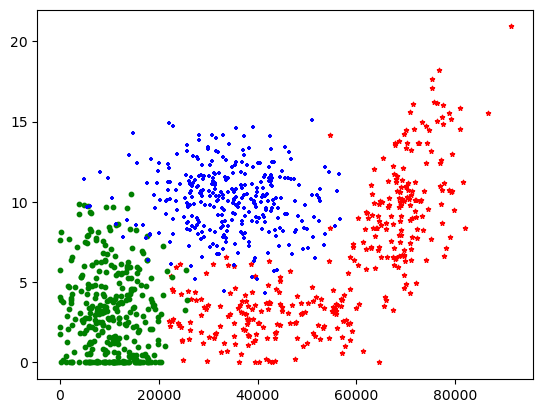

In [8]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
fig = plt.figure()
ax = fig.add_subplot(111) #感觉跟matlab相似，应该是新建1x1在1号位的子图
#设置x轴和y轴，区分不同样本分类
datingLabels = np.array(datingLabels)
id_1 = np.where(datingLabels==1)
p1 = ax.scatter(datingDataMat[id_1, 0], datingDataMat[id_1, 1], marker='*', color='r', label='1',s=10)
id_2 = np.where(datingLabels==2)
p2 = ax.scatter(datingDataMat[id_2, 0], datingDataMat[id_2, 1], marker='o', color='g', label='1',s=10)
id_3 = np.where(datingLabels==3)
p3 = ax.scatter(datingDataMat[id_3, 0], datingDataMat[id_3, 1], marker='+', color='b', label='1',s=10)

#plt.xlabel(u'每年获得的飞行常客里程数', fontproperties=zhfont)
#plt.ylabel(u'玩视频游戏所耗时间百分比', fontproperties=zhfont)
#ax.legend((p1, p2, p3), (u'不喜欢', u'魅力一般', u'极具魅力'), loc=2)
plt.show()

## 归一化数值
数字差值最大的属性对距离的计算结果影响最大。因此需要进行归一化来平等三个特征的权重。  
常见的归一化应该是将数值映射成[0, 1]或者 [-1, 1],使用以下公式  
newValue = ((oldValue - min)*(b - a)/(max -min)) + a      其中 [a, b]  
之前看李沐老师的视频，有四种常用的标准化的公式  
只记得一个log了  

In [9]:
def autoNorm(dataSet):
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = np.zeros(np.shape(dataSet))
    m = dataSet.shape[0]
    normDataSet = dataSet - np.tile(minVals, (m, 1))
    normDataSet = normDataSet/np.tile(ranges, (m, 1))
    return normDataSet, ranges, minVals

In [10]:
normMat, ranges, minVals = autoNorm(datingDataMat)
print(normMat)
print(ranges)
print(minVals)

[[0.44832535 0.39805139 0.56233353]
 [0.15873259 0.34195467 0.98724416]
 [0.28542943 0.06892523 0.47449629]
 ...
 [0.29115949 0.50910294 0.51079493]
 [0.52711097 0.43665451 0.4290048 ]
 [0.47940793 0.3768091  0.78571804]]
[9.1273000e+04 2.0919349e+01 1.6943610e+00]
[0.       0.       0.001156]


## 测试算法

In [11]:
def datingClassTest():
    hoRatio = 0.10 #随机选取10%的数据进行测试
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
    normMat, ranges, minVals = autoNorm(datingDataMat)
    m = normMat.shape[0]
    numTestVecs = int(m*hoRatio)
    errorCount = 0.0
    for i in range(numTestVecs):
        classifierResult = classify0(normMat[i, :], normMat[numTestVecs:m, :],\
            datingLabels[numTestVecs:m], 3)
        print("The classifier came back with: {0}, the real answer is {1}".format(classifierResult, datingLabels[i]))

        if (classifierResult != datingLabels[i]) : errorCount += 1.0
    print("The total error rate is: {0}".format(errorCount/float(numTestVecs)))



In [12]:
datingClassTest()

The classifier came back with: 3, the real answer is 3
The classifier came back with: 2, the real answer is 2
The classifier came back with: 1, the real answer is 1
The classifier came back with: 1, the real answer is 1
The classifier came back with: 1, the real answer is 1
The classifier came back with: 1, the real answer is 1
The classifier came back with: 3, the real answer is 3
The classifier came back with: 3, the real answer is 3
The classifier came back with: 1, the real answer is 1
The classifier came back with: 3, the real answer is 3
The classifier came back with: 1, the real answer is 1
The classifier came back with: 1, the real answer is 1
The classifier came back with: 2, the real answer is 2
The classifier came back with: 1, the real answer is 1
The classifier came back with: 1, the real answer is 1
The classifier came back with: 1, the real answer is 1
The classifier came back with: 1, the real answer is 1
The classifier came back with: 1, the real answer is 1
The classi

## 约会网站预测函数

In [13]:
def classifyPerson():
    resultList = ['not at all', 'in small doses', 'in large doses']
    percentTats = float(input("percentage of time spent playing video games?"))
    ffMiles = float(input("frequent flier miles earned per year?"))
    iceCream = float(input("liters of ice cream consumed per year?"))
    inArr = np.array([ffMiles, percentTats, iceCream])
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
    normMat, ranges, minVals = autoNorm(datingDataMat)
    normInArr = (inArr-minVals)/ranges
    classifierResult = classify0(normInArr, normMat, datingLabels, 3)
    print("You will probably like this person: {0}".format(resultList[classifierResult - 1]))

In [14]:
classifyPerson()

You will probably like this person: in small doses


# 手写识别系统
只能简单的识别数字0到9  
使用的图像为32像素x32像素的黑白图像  
步骤基本与之前相同  
但是需要将图像格式转化为文本格式  
为了使用之前实现的分类器，需要将32x32转化为1x1024的向量  

Notice:  
改变变量k的值，随机选取训练样本、改变训练样本数目，都会对kNN算法的错误率产生影响。

In [15]:
import os

def img2vector(filename):
    returnVect = np.zeros((1, 1024))
    with open(filename) as fr:
        for i in range(32):
            lineStr = fr.readline()
            for j in range(32):
                returnVect[0, 32*i + j] = int(lineStr[j])
    return returnVect
    
def handwritingClassTest():
    '''因为数据在多个文件中，因此要获取文件目录'''
    hwLabels = []
    trainingFileList = os.listdir('trainingDigits')
    m = len(trainingFileList)
    trainingMat = np.zeros((m, 1024))

    for i in range(m):
        fileNameStr = trainingFileList[i]
        '''从文件名获取标签'''
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        hwLabels.append(classNumStr)
        trainingMat[i, :] = img2vector('trainingDigits/{0}'.format(fileNameStr))
    
    testFileList = os.listdir('testDigits')
    errorCount = 0.0
    mTest = len(testFileList)
    for i in range(mTest):
        fileNameStr = testFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        vectorUnderTest = img2vector('testDigits/{0}'.format(fileNameStr))
        classifierResult = classify0(vectorUnderTest, trainingMat, hwLabels, 3)
        print("The classifier came back with: {0}, the real answer is: {1}".format(classifierResult, classNumStr))

        if (classifierResult != classNumStr): errorCount += 1.0
    print("The total number of errors is: {0}".format(errorCount))
    print("The total error rate is: {0}".format(errorCount/float(mTest)))

handwritingClassTest()

The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answer is: 0
The classifier came back with: 0, the real answe

# Notices
k-近邻算法是分类数据最简单有效的算法。 但是存在着一下几点问题。
1. 是基于实例的学习，使用算法时必须有接近实际数据的训练样本数据
2. 必须保存全部数据集，如果数据集很大，必须使用大量的存储空间
3. 必须对数据集中的每个数据计算距离值，实际使用时非常耗时
4. 无法给出任何数据的基础结构信息，无法知晓平均实例样本和典型实例样本具有什么特征  

k决策树就是kNN算法的优化版，能够节省大量的计算开销。